In [1]:
!pip install -q tensorflow-addons==0.9.1    # 補充包，裡面有一些好用的功能，這裡用到計算F1的funciton
!pip install -q image-classifiers==1.0.0    # 預訓練模型包，可拿一些人家預訓練的模型來用
# !pip install -q efficientnet==1.1.0         # 預訓練模型包

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import math, re, os, glob, time, random
from collections import namedtuple
from functools import partial

import numpy as np
import pandas as pd
import tensorflow as tf

import tensorflow_addons as tfa
from classification_models.tfkeras import Classifiers
# import efficientnet.tfkeras as efn

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from kaggle_datasets import KaggleDatasets

import seaborn as sns
from matplotlib import pyplot as plt

print("Tensorflow version " + tf.__version__)

K = tf.keras.backend
L = tf.keras.layers
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


# TPU/GPU detection

In [3]:
# Detect hardware, return appropriate distribution strategy
def get_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
        # Returns a ClusterSpec object based on the latest TPU information(取得TPU叢集資訊，以及網路連接端口)
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)     # Connects to the given cluster, Will make devices on the cluster available to use
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

    print("REPLICAS: ", strategy.num_replicas_in_sync)
    
    return strategy

strategy = get_strategy()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Configuration

In [9]:
# data setup
SEED = 61
# GCS_PATH = KaggleDatasets().get_gcs_path('shopee-product-detection-open')  # 從GCS端口取得該檔案位置絕對路徑
GCS_PATH_2 = KaggleDatasets().get_gcs_path('sp-tfrecords')
DATA_PATH = '/kaggle/input/shopee-product-detection-open/'
CLASSES = sorted(os.listdir(DATA_PATH + 'train/train/train'))
IM_SZ = 224  # 320, 384, 448, 512
IMAGE_SIZE = [IM_SZ, IM_SZ]


# training setup
EPOCHS = 7
BATCH_SIZE = 16 * strategy.num_replicas_in_sync    # 根據TPU document，建議為128可使其運算效率最大
LR = 1e-4

random.seed(SEED)
np.random.seed(SEED)


# Data Pipline

In [10]:
# for caffe preproc mode
MEAN_C = [123.68, 116.779, 103.939]

# for torch preproc mode
MEAN_T = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def decode_image(image, mode=None): # 將image 轉成 符合 pre-trained model 對 input data的要求
    assert mode in (None, 'tf', 'torch', 'caffe'), "mode must be one of None, 'tf', 'torch', 'caffe'"
    image = tf.image.decode_jpeg(image, channels=3)  # binary code => tf.Tensor(uint8)  (H, W, C)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    if mode is None:  
        return image
    if mode == 'tf':
        image = image / 255.0  # convert image to floats in [0, 1] range
    if mode == 'torch':
        image = image / 255.0
        image = (image - MEAN_T) / STD
    if mode == 'caffe':
        image = image - MEAN_C
    return image

def deprocessing(image, mode=None):   # 將image 轉成 適合visualization 的size
    assert mode in (None, 'tf', 'torch', 'caffe'), "mode must be one of None, 'tf', 'torch', 'caffe'"
    def rescale(x):
        low, high = x.min(), x.max()
        x_rescaled = (x - low) / (high - low)
        return x_rescaled
    if mode is None or mode == 'tf':
        return rescale(image)
    if mode == 'torch':
        return rescale(image * STD + MEAN_T)  # image 在此時已經被轉成符合 pre-trained model的要求格式，所以要轉回來
    if mode == 'caffe':
        return rescale(image + MEAN_C)

# 一次處理(one image, one lebel)，轉成tf.Tensor type ，返回
def read_labeled_tfrecord(example):     
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring  # 這個物件類似tf.placeholder()
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)   # get binary code of one image,設定 UNLABELED_TFREC_FORMAT 讓返回的物件是dict
    image = decode_image(example['image'])                                # decode_image 把binary code 轉成tf.Tensor(unit8) 並resize圖形大小    
    label = tf.one_hot(tf.cast(example['label'], tf.int32), len(CLASSES)) # 做one-hot 返回 vector
    return image, label    # # (H, W, C) , (K, )

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  
        "filename": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])          
    filename = example['filename']
    return image, filename

def data_augment(image, label, p_hsv=0.5, p_affine=0.7, p_cutout=0.3):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    r_hsv = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    r_affine = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    r_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    
    image = tf.image.random_flip_left_right(image)
    if r_hsv < p_hsv:
        image = tf.image.random_brightness(image, 0.15)
        image = tf.image.random_saturation(image, 0.8, 2.3)
        image = tf.image.random_contrast(image, 0.8, 1.3)
    if r_affine < p_affine:
        image = shift_scale_rotate(image, h_shift=0.1*IM_SZ, w_shift=0.1*IM_SZ)
    if r_cutout < p_cutout:
        image = cutout(image)
    
    return image, label

def get_training_dataset():
    dataset = tf.data.TFRecordDataset(TRAIN_FILENAMES, num_parallel_reads=AUTO) 
    return (
        dataset
        .map(read_labeled_tfrecord, num_parallel_calls=AUTO)
        .cache()
        .map(data_augment, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(100000)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )   # tuple(image(N, H, W, C) tf.float(0.0~255.0), (N, K) tf.int32)                                   

# 理解為計算圖的設計稿，返回所有sample(有分成數個batch)
def get_validation_dataset():
    dataset = tf.data.TFRecordDataset(VALID_FILENAMES, num_parallel_reads=AUTO) 
    # VALID_FILENAMES，是個list， 只有對應到一個 .tfrec 檔案
    # type(dataset) => TFRecordDatasetV2
    # The TFRecord format is a simple format for storing a sequence of binary records.
    # dataset => 返回一大包資料，裡面是數個example(每個example =>one image ,one label)
    return (
        dataset
        .map(read_labeled_tfrecord, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )   # tuple(image(N, H, W, C) tf.float(0.0~255.0), (N, K) tf.int32)  

def get_test_dataset():
    dataset = tf.data.TFRecordDataset(TEST_FILENAMES, num_parallel_reads=AUTO)
    return (
        dataset
        .map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
    )

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Augmentation

In [11]:
def transform(image, matrix, border_mode=0):
    BORDERS = ['constant', 'nearest']
    border_mode = BORDERS[border_mode]
    
    DIM = IMAGE_SIZE[0]
    C = DIM // 2
    
    # LIST DESTINATION PIXEL INDICES
    y, x = tf.meshgrid(tf.range(DIM), tf.range(DIM))
    x_c, y_c = tf.reshape(x - C, [-1]), tf.reshape(y - C, [-1])
    x, y = tf.reshape(x, [-1]), tf.reshape(y, [-1])
    if matrix.shape[0] == 2:
        coord = tf.stack( [x_c,y_c] )   # (2, DIM*DIM)
    else:
        z = tf.ones([DIM*DIM], dtype='int32')
        coord = tf.stack( [x_c,y_c,z] )   # (3, DIM*DIM)
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    coord_pr = tf.matmul(matrix, tf.cast(coord, dtype='float32'))
    coord_pr = tf.cast(tf.round(coord_pr[:2,:] + C), dtype='int32')   # (2, DIM*DIM)
    
    # FIND ORIGIN PIXEL VALUES
    if border_mode == 'constant':
        x_pr, y_pr = coord_pr[0,:], coord_pr[1,:]
        outside_ind = tf.logical_or( tf.logical_or(y_pr>DIM-1 , y_pr<0), tf.logical_or(x_pr>DIM-1 , x_pr<0))

        x_pr = tf.boolean_mask(x_pr, tf.logical_not(outside_ind))   # (<DIM*DIM, )
        y_pr = tf.boolean_mask(y_pr, tf.logical_not(outside_ind))   # (<DIM*DIM, )
        x    = tf.boolean_mask(x, tf.logical_not(outside_ind))   # (<DIM*DIM, )
        y    = tf.boolean_mask(y, tf.logical_not(outside_ind))   # (<DIM*DIM, )

        coord_pr = tf.transpose( tf.stack( [x_pr, y_pr] ) )   # (<DIM*DIM, 2)
        coord = tf.cast(tf.transpose( tf.stack( [x, y] ) ), 'int64')   # (<DIM*DIM, 2)

        im_channels = tf.split(image, 3, axis=-1)
        rot_channels = []
        for im_val in im_channels:
            rot_val = tf.squeeze(tf.gather_nd(im_val, coord_pr), axis=-1)   # (<DIM*DIM, )
            rot = tf.SparseTensor(coord, rot_val, [DIM, DIM])
            rot_channels.append(tf.sparse.to_dense(rot, default_value=0, validate_indices=False))

        rot_image = tf.transpose(tf.stack(rot_channels), [1, 2, 0])   # (DIM, DIM, 3)
    
    if border_mode == 'nearest':
        coord_pr = tf.clip_by_value(coord_pr, 0, DIM - 1)   # (2, DIM*DIM)
        rot_image = tf.reshape( tf.gather_nd(image, tf.transpose(coord_pr)), [DIM, DIM, 3] )
    
    return rot_image

def rotate(image, angle):
    angle = math.pi * angle / 180.
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    t_matrix = tf.reshape( tf.stack([c1,s1, -s1,c1]), [2,2] )
    return transform(image, t_matrix)

def shear(image, angle):
    angle = math.pi * angle / 180.
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    t_matrix = tf.reshape( tf.stack([one[0],s1, zero[0],c1]), [2,2] )
    return transform(image, t_matrix)

def zoom(image, height_zoom, width_zoom):
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    t_matrix = tf.reshape( tf.stack([one[0]/height_zoom,zero[0], zero[0],one[0]/width_zoom]), [2,2] )
    return transform(image, t_matrix)

def shift(image, height_shift, width_shift):
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    t_matrix = tf.reshape( tf.stack([one[0],zero[0],height_shift, zero[0],one[0],width_shift, zero[0],zero[0],one[0]]), [3,3] )
    return transform(image, t_matrix)

def shift_scale_rotate(image, rotation=15, shear=8, h_zoom=1, w_zoom=1, h_shift=20, w_shift=20):
    rot = rotation * tf.random.normal([1], dtype='float32')
    shr = shear * tf.random.normal([1], dtype='float32')
    h_zoom = h_zoom + tf.random.normal([1], dtype='float32') / 10.
    w_zoom = w_zoom + tf.random.normal([1], dtype='float32') / 10.
    h_shift = h_shift * tf.random.normal([1], dtype='float32')
    w_shift = w_shift * tf.random.normal([1], dtype='float32')
    
    angle = math.pi * rot / 180.
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rot_matrix = tf.reshape( tf.concat([c1,s1, -s1,c1], axis=0), [2,2] )
    
    angle = math.pi * shr / 180.
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    shr_matrix = tf.reshape( tf.concat([one,s1, zero,c1], axis=0), [2,2] )
    
    z_matrix = tf.reshape( tf.concat([one/h_zoom,zero, zero,one/w_zoom], axis=0), [2,2] )
    
    t_matrix = K.dot(K.dot(rot_matrix, shr_matrix), z_matrix)
    t_image = transform(image, t_matrix)
    
    s_matrix = tf.reshape( tf.concat([one,zero,h_shift, zero,one,w_shift, zero,zero,one], axis=0), [3,3] )
    return transform(t_image, s_matrix)

def cutout(image, min_height=0.4, min_width=0.4, max_height=0.6, max_width=0.6):
    DIM = IMAGE_SIZE[0]
    
    cut_height = tf.cast(tf.round(tf.random.uniform([], minval=min_height*DIM, maxval=max_height*DIM)), 'int32')
    cut_width = tf.cast(tf.round(tf.random.uniform([], minval=min_width*DIM, maxval=max_width*DIM)), 'int32')
    x_min = tf.random.uniform([], minval=-cut_width//2, maxval=DIM-1-cut_width//2, dtype='int32')
    x_max = x_min + cut_width
    y_min = tf.random.uniform([], minval=-cut_height//2, maxval=DIM-1-cut_height//2, dtype='int32')
    y_max = y_min + cut_height
    if x_min < 0:
        cut_width -= 0 - x_min
        x_min = tf.clip_by_value(x_min, 0, x_max)
    if y_min < 0:
        cut_height -= 0 - y_min
        y_min = tf.clip_by_value(y_min, 0, y_max)
    if x_max > DIM:
        cut_width -= x_max - DIM
        x_max = tf.clip_by_value(x_max, x_min, DIM)
    if y_max > DIM:
        cut_height -= y_max - DIM
        y_max = tf.clip_by_value(y_max, y_min, DIM)
    
    cut_area = tf.zeros([cut_height, cut_width, 3], dtype='float32')
    pad_top = y_min
    pad_bottom = DIM - y_max
    pad_left = x_min
    pad_right = DIM - x_max
    cut_mask = tf.pad(cut_area, [[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    
    cut_image = tf.multiply(image, cut_mask)
    return cut_image

# Visualization Utilities

In [12]:
np.set_printoptions(threshold=15, linewidth=80)


def batch_to_numpy_images_and_labels(data, to_deprocess=False):
    try:
        images, labels = data
        numpy_images = images.numpy()
        numpy_labels = labels.numpy().astype('int32')  # 為了之後讓im.show()畫圖，這邊轉從float轉成int
        
    except:
        # test data 再轉成batch後，tuple裡面是 (images, filenames)，filenames都是字串，所以這裡補上轉型成int是為了讓它跑到例外處裡那段
        # test data 走的code如下
        images, filenames = data
        numpy_images = images.numpy()
        numpy_labels = None
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    if to_deprocess:
        numpy_images = np.stack([deprocessing(im) for im in numpy_images])
    return numpy_images, numpy_labels


def display_one_sample(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)       # plt.imshow() 不能讀懂float型別，只能讀懂int型別，或者是 0~1之間的 tf.float, 或是 tf.int32
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images(databatch, predictions=None, to_deprocess=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch, to_deprocess)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    else:
        labels = np.argmax(labels, -1)
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_sample(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
    
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

def display_training_curves(training, validation, title, subplot, figsize=(8,10)):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=figsize)
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Datasets

In [13]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')

NUM_TRAIN_IMAGES = train_df.shape[0]
NUM_TEST_IMAGES = test_df.shape[0]

print('Num. of train images:', NUM_TRAIN_IMAGES)
print('Num. of test images:', NUM_TEST_IMAGES)

Num. of train images: 105390
Num. of test images: 12186


In [14]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH_2 + '/train/*.tfrec')    # 把資料集裡面 train 資料夾裡面的所有檔案路徑都讀出，記錄在list內返回
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH_2 + '/test/*.tfrec')

print(len(TEST_FILENAMES))
print(TEST_FILENAMES)


2
['gs://kds-381cd778f62ce3d047affc3212a5a7d9ae1bf748cdbd79810a1223f1/test/00-224x224-6093.tfrec', 'gs://kds-381cd778f62ce3d047affc3212a5a7d9ae1bf748cdbd79810a1223f1/test/01-224x224-6093.tfrec']


## Train/Validation split

In [15]:
TRAIN_FILENAMES = TRAINING_FILENAMES[1:]     
VALID_FILENAMES = [TRAINING_FILENAMES[0]]      # 把資料集裡面 train 資料夾內的第一個檔案路徑拿出來，並且包在list內，這樣就跟上面的樣式一致

In [16]:
NUM_TRAIN_IMAGES = count_data_items(TRAIN_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
STEPS_PER_EPOCH = math.ceil(NUM_TRAIN_IMAGES / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(NUM_VALIDATION_IMAGES / BATCH_SIZE)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAIN_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 100121 training images, 5269 validation images, 12186 unlabeled test images


In [17]:
DATA_PATH = '../input/shopee-product-detection-open/train/train/train/01/'
im_files = os.listdir('../input/shopee-product-detection-open/train/train/train/01')

(700, 700, 3)


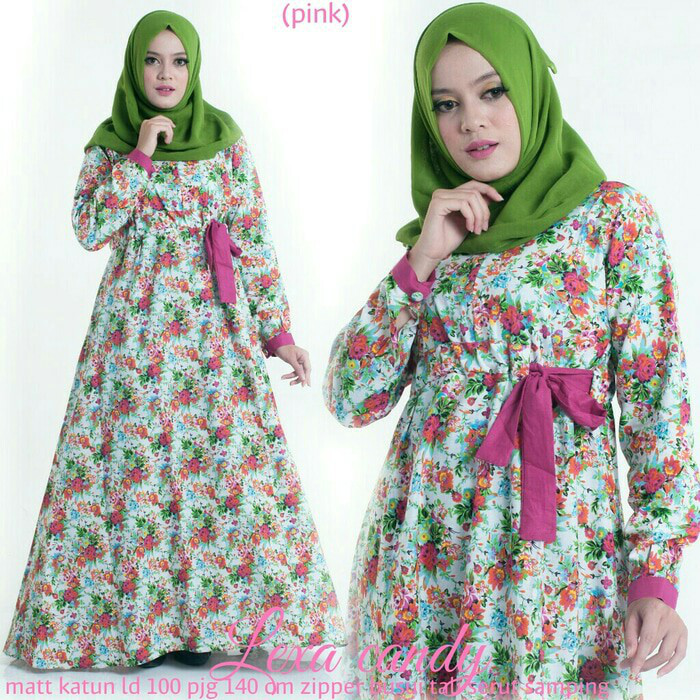

In [18]:
from PIL import Image

im = Image.open(DATA_PATH + im_files[655])
print(np.array(im).shape)
im

## Dataset Visualization

In [22]:
# Peek at valid data
val_dataset = get_validation_dataset()     # 理解為計算圖的設計稿，返回所有sample(有分成數個batch)
val_dataset = val_dataset.unbatch().batch(20)    # 轉成每20個sample一個batch，
val_batch = iter(val_dataset)  # 讓它變成generator

(20, 224, 224, 3)
(20, 42)


(1, 1, 2)

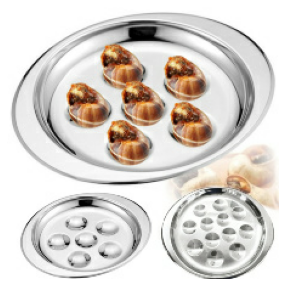

In [23]:
images, labels = next(val_batch)  # 利用generator 一次抽出一個batch的資料 ，使用next(val_batch) 會給出 tuple(images, labels)
print(images.shape)
print(labels.shape)
plt.figure(figsize=(5, 5))
display_one_sample(tf.cast(images[1], tf.int32), '', (1,1,1))  # images[0]這裡是2~255之前的tf.float  # plt.imshow() 不能讀懂float型別，只能讀懂int型別，或者是 0~1之間的 tf.float, 或是 tf.int32

In [24]:
# images, labels = batch_to_numpy_images_and_labels(next(val_batch), to_deprocess=False)   # 這裡轉成 array型別
# plt.figure(figsize=(5, 5))
# display_one_sample(tf.cast(images[1], tf.int32) , "", (1,1,1))

### test augmentation

(1, 1, 2)

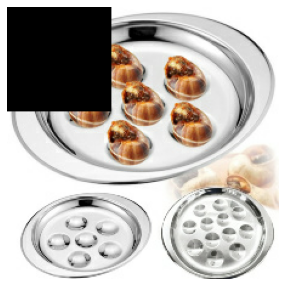

In [25]:
plt.figure(figsize=(5, 5))
display_one_sample(tf.cast(cutout(images[1]), tf.int32), '', (1,1,1))

(1, 1, 2)

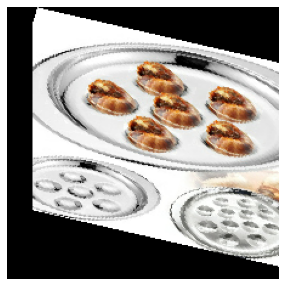

In [26]:
plt.figure(figsize=(5, 5))
display_one_sample(tf.cast(shift_scale_rotate(images[1]), tf.int32), '', (1,1,1))

(1, 1, 2)

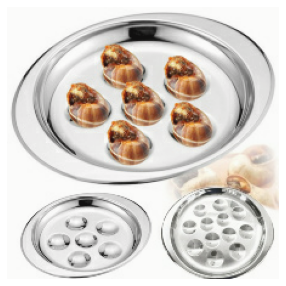

In [27]:
plt.figure(figsize=(5, 5))
display_one_sample(tf.cast(tf.image.random_contrast(images[1], 0.8, 2.3), tf.int32), '', (1,1,1))

(1, 1, 2)

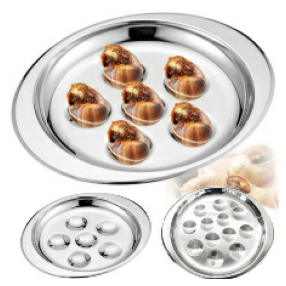

In [28]:
plt.figure(figsize=(5, 5))
display_one_sample(tf.cast(tf.image.random_saturation(images[1], 0.8, 2.3), tf.int32), '', (1,1,1))

(1, 1, 2)

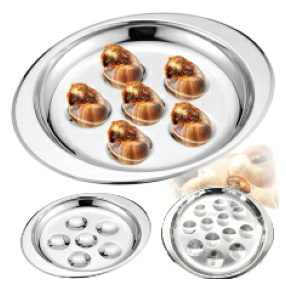

In [30]:
plt.figure(figsize=(5, 5))
display_one_sample(tf.cast(tf.image.random_brightness(images[1], 10), tf.int32), '', (1,1,1))

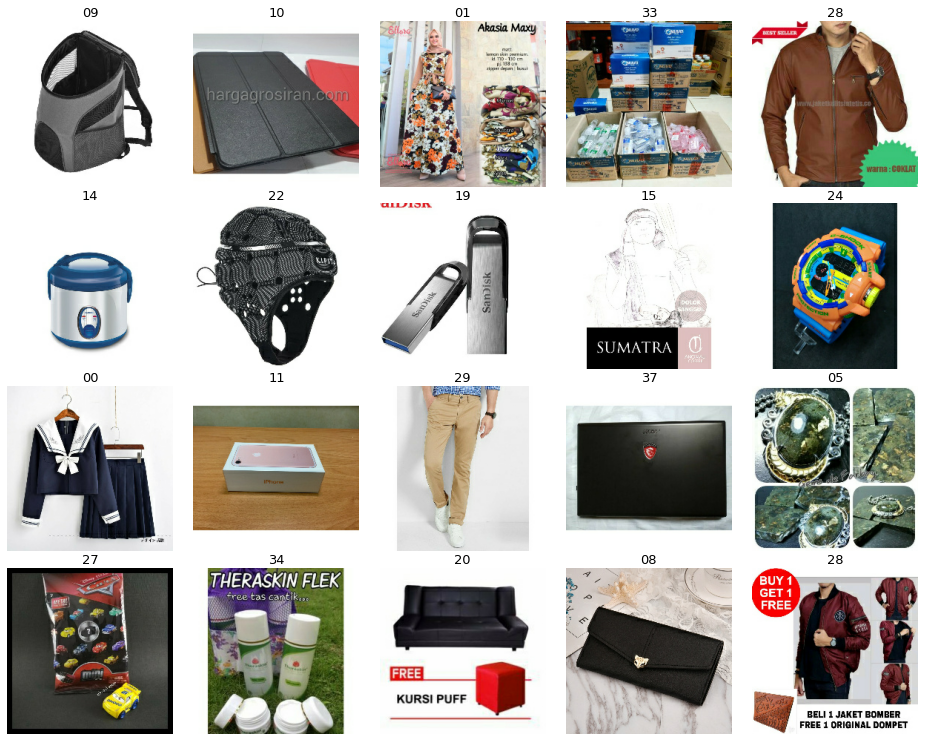

In [31]:
display_batch_of_images(next(val_batch), to_deprocess=True)

In [36]:
# Peek at training data
train_dataset = get_training_dataset()
train_dataset = train_dataset.unbatch().batch(20)
train_batch = iter(train_dataset)   # 這個iterator可以一次抽出一個batch的資料 ，使用next(train_batch)會給出 tuple(images, labels)

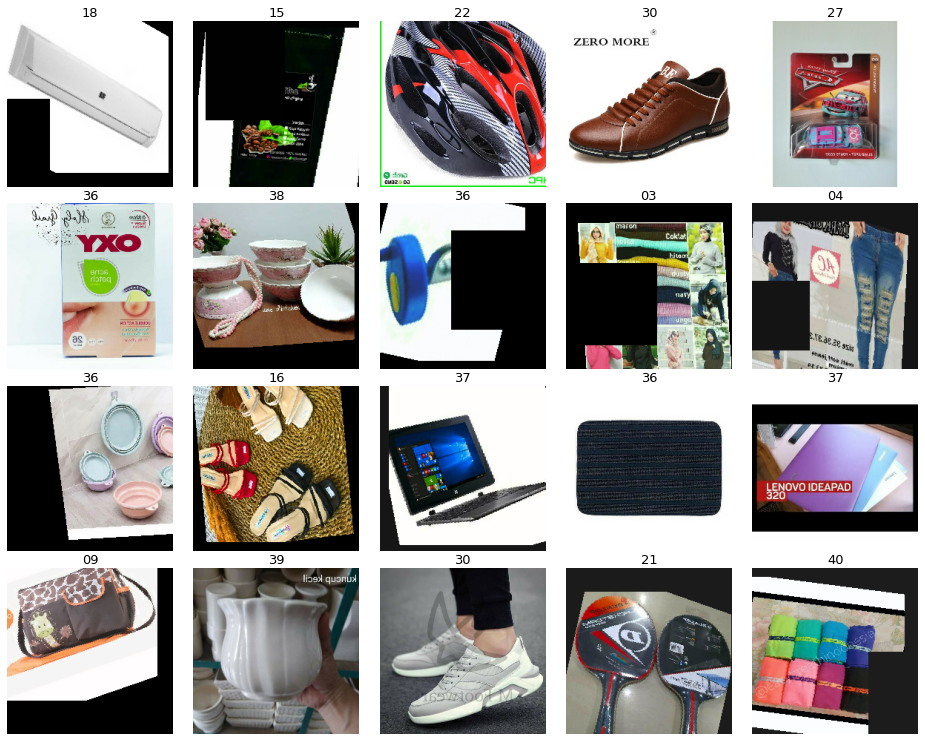

In [37]:
# run this cell again for next set of images
# longer because of the augmentation process
display_batch_of_images(next(train_batch), to_deprocess=True)   # input 是一個batch的資料，會是 tuple(images, labels)  
                                                                # 故意用 to_deprocess=True 可以透過 deprocessing 將 image從0~255的tf.float 轉成 0~1的tf.float，im.show()才能秀出來

# Keras

In [38]:
strategy = get_strategy()

with strategy.scope():
    resnet, _ = Classifiers.get('resnet50')
    pretrain_model = resnet(weights='imagenet', 
                           include_top=False, 
                           input_shape=[*IMAGE_SIZE, 3])
    pretrain_model.trainable = True    # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        pretrain_model, 
        L.GlobalAveragePooling2D(), 
        L.Dense(len(CLASSES), activation='softmax')
    ])
    
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=tf.keras.optimizers.Adam(lr=LR),
        metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                tfa.metrics.F1Score(len(CLASSES), average='macro', threshold=None)]
    )
    
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5', 
        save_weight_only=True, 
        monitor='val_categorical_accuracy', 
        save_best_only=True
    )
    
    model.summary()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
94593024/94592056 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 2048)        23546057  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 42)                86058     
Total params: 23,632,115
Trainable params: 23,586,541
Non-trainable params: 45,574
_________________________________________________________________


In [39]:
start_time = time.time()

history = model.fit(
    get_training_dataset(),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=get_validation_dataset(),
    callbacks=[ckpt_callback]
)

keras_fit_training_time = time.time() - start_time
print("KERAS FIT TRAINING TIME: {:0.1f}s".format(keras_fit_training_time))

model.load_weights('best_model.h5')

Epoch 1/7
783/783 [==============================] - 90s 114ms/step - categorical_accuracy: 0.6170 - f1_score: 0.6141 - loss: 1.8857 - val_categorical_accuracy: 0.7273 - val_f1_score: 0.7259 - val_loss: 1.5718
Epoch 2/7
783/783 [==============================] - 73s 93ms/step - categorical_accuracy: 0.7057 - f1_score: 0.7051 - loss: 1.6015 - val_categorical_accuracy: 0.7480 - val_f1_score: 0.7456 - val_loss: 1.5094
Epoch 3/7
783/783 [==============================] - 76s 97ms/step - categorical_accuracy: 0.7373 - f1_score: 0.7378 - loss: 1.5069 - val_categorical_accuracy: 0.7628 - val_f1_score: 0.7628 - val_loss: 1.4870
Epoch 4/7
783/783 [==============================] - 72s 92ms/step - categorical_accuracy: 0.7579 - f1_score: 0.7584 - loss: 1.4416 - val_categorical_accuracy: 0.7574 - val_f1_score: 0.7596 - val_loss: 1.5086
Epoch 5/7
783/783 [==============================] - 74s 95ms/step - categorical_accuracy: 0.7749 - f1_score: 0.7759 - loss: 1.3869 - val_categorical_accuracy: 0.7

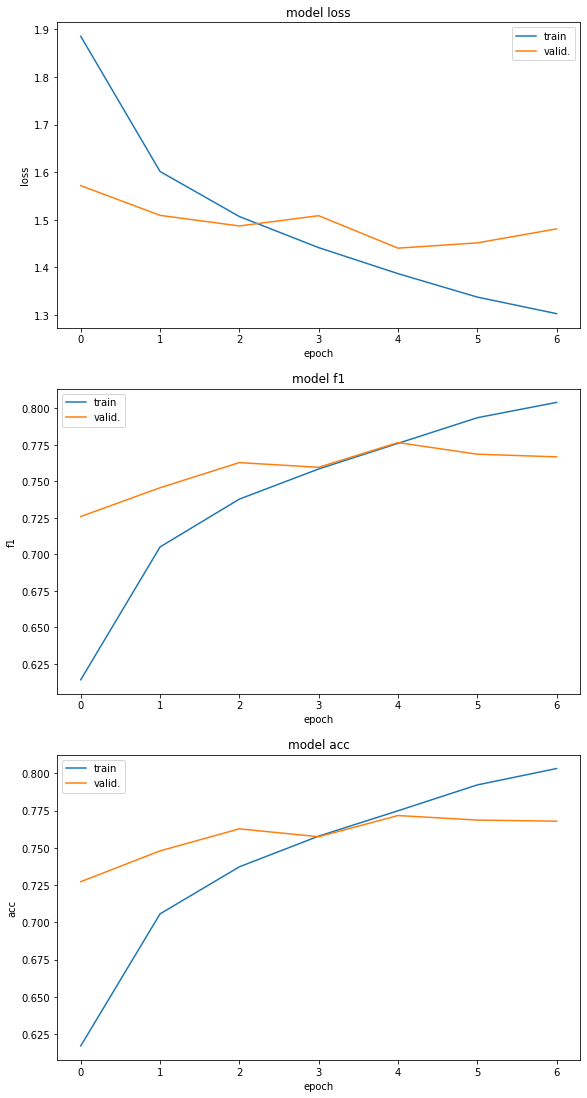

In [40]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 311, figsize=(8,15))
display_training_curves(history.history['f1_score'], history.history['val_f1_score'], 'f1', 312)
display_training_curves(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 'acc', 313)

# Validation

In [41]:
%%time

val_dataset = get_validation_dataset()
images_ds = val_dataset.map(lambda image, label: image)
labels_ds = val_dataset.map(lambda image, label: label).unbatch()
valid_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
valid_labels = np.argmax(valid_labels, -1)

valid_preds = model.predict(images_ds)
valid_preds = np.argmax(valid_preds, axis=-1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fb1de2a00e0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fb1de2a04d0>. Note that functions defined in certain environments, like the interactive Python shell do no

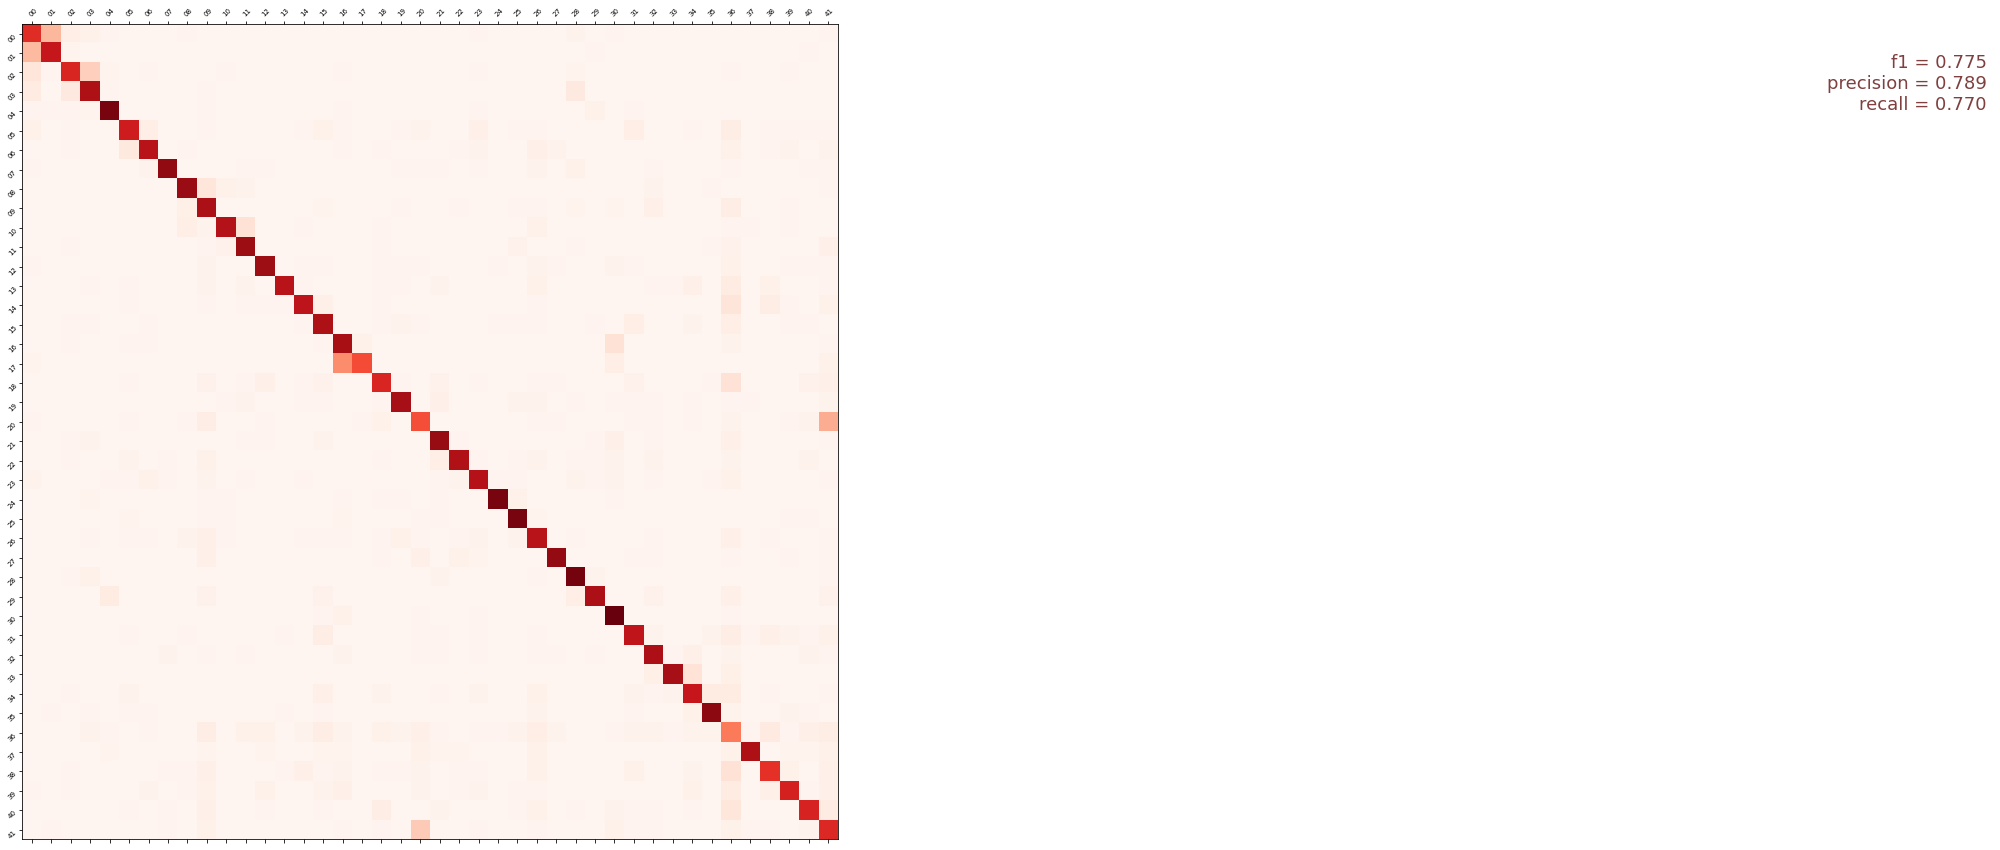

accuracy: 0.770, f1 score: 0.775, precision: 0.789, recall: 0.770


In [42]:
val_acc = accuracy_score(valid_labels, valid_preds)
val_f1 = f1_score(valid_labels, valid_preds, labels=range(len(CLASSES)), average='macro')
val_prec = precision_score(valid_labels, valid_preds, labels=range(len(CLASSES)), average='macro')
val_rec = recall_score(valid_labels, valid_preds, labels=range(len(CLASSES)), average='macro')

cmat = confusion_matrix(valid_labels, valid_preds, labels=range(len(CLASSES)))
cmat = (cmat.T / cmat.sum(axis=1)).T  # normalized

display_confusion_matrix(cmat, val_f1, val_prec, val_rec)
print('accuracy: {:.3f}, f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(val_acc, val_f1, val_prec, val_rec))